# **Lung Cancer Histopathology Using CNN Techniques**

## **Data Ingestion**

In [1]:
import kagglehub
lung_cancer_data = kagglehub.dataset_download('andrewmvd/lung-and-colon-cancer-histopathological-images')

print('Data source import complete.')

Using Colab cache for faster access to the 'lung-and-colon-cancer-histopathological-images' dataset.
Data source import complete.


In [2]:
import os

data_path = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets"
#data_path = "C:/Users/manni/Downloads/Lung Cancer Data/lung_colon_image_set/lung_image_sets"
images_list = []
for dir_paths, dir_name, filenames in os.walk(data_path):
    if len(filenames) > 0:
        for filename in filenames:
            images_list.append(dir_paths + "/" + filename)

images_list[:5]

['/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca/lungaca2056.jpeg',
 '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca/lungaca1914.jpeg',
 '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca/lungaca3989.jpeg',
 '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca/lungaca3803.jpeg',
 '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca/lungaca861.jpeg']

In [3]:
import random
import matplotlib.pyplot as plt
from PIL import Image

#random.seed(42)
for i in range(5):
    image_path = random.choice(images_list)
    label = image_path.split("/")[-2]
    image = Image.open(image_path)
    height = image.height
    width = image.width
    print("Disease: ", label)
    print("Dimension: ", height, "by", width)
    display(image)
    print('\n')

Output hidden; open in https://colab.research.google.com to view.

## **Importing Pytorch and Setting Angnostic mode**

In [4]:
import torch
from torch import nn

torch.__version__

'2.8.0+cu126'

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
from google.colab import drive
drive.mount('MyDrive')

import os
os.chdir("/content/MyDrive/MyDrive/Lung Cancer Detection")

Mounted at MyDrive


In [7]:
os.getcwd()

'/content/MyDrive/MyDrive/Lung Cancer Detection'

## Data Preparation

In [8]:
from preprocessing import prepare_data

train_loader, test_loader, classes = prepare_data(data_path = data_path, random_state = 1)

In [9]:
print(classes)

full_class_names = ['Adenocarcinoma', 'Benign', 'Squamous Cell Carcinoma']

['lung_aca', 'lung_n', 'lung_scc']


## Baseline Model (TinyVGG)

In [10]:
class TinyVGG (nn.Module):
    def __init__(self, input_shape, hidden_units = 10, kernel_size = 3):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape, out_channels=hidden_units, kernel_size= kernel_size),
            nn.Tanh(),
            nn.Conv2d(in_channels = hidden_units, out_channels=hidden_units, kernel_size= kernel_size),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = hidden_units, out_channels=hidden_units, kernel_size= kernel_size),
            nn.Tanh(),
            nn.Conv2d(in_channels = hidden_units, out_channels=hidden_units, kernel_size= kernel_size),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )


        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_units * (kernel_size + hidden_units)**2, out_features = 4)
            #nn.Linear(in_features = hidden_units * (kernel_size + 10)**2, out_features = 4)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.classifier(x)
        return x


In [11]:
model_1 = TinyVGG(input_shape = 3)
model_1

TinyVGG(
  (layer1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): Tanh()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): Tanh()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): Tanh()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): Tanh()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=4, bias=True)
  )
)

In [12]:
try:
    from torchinfo import summary
except:
    !pip install torchinfo --quiet
    from torchinfo import summary

summary(model_1, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 4]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─Tanh: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─Tanh: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─Tanh: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─Tanh: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [13]:
#from importlib import reload
#reload(engine)

In [14]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import engine

model_1 = TinyVGG(input_shape = 3)


results = engine.train_loop(
    model = model_1,
    loss_fn = nn.CrossEntropyLoss(),
    optimizer = torch.optim.Adam(params = model_1.parameters(), lr = 0.001),
    train_loader =  train_loader,
    test_loader = test_loader,
    epochs = 25,
    device = device
)

results

  0%|          | 0/25 [00:00<?, ?it/s]

,Epoch,Train Accuracy,Train Loss,Test Accuracy,Test Loss
0,1,77.346125,0.471173,84.082447,0.369351
1,2,89.162234,0.275518,90.053191,0.252982
2,3,91.631839,0.214944,92.070035,0.210238
3,4,92.543693,0.197406,92.016844,0.222511
4,5,93.018617,0.182244,91.994681,0.195606
5,6,93.075608,0.180174,92.371454,0.192547
6,7,93.313070,0.175098,92.881206,0.180273
7,8,93.958967,0.164482,92.681738,0.175150
8,9,94.148936,0.153323,93.900709,0.158953
9,10,94.642857,0.140139,93.479610,0.189935


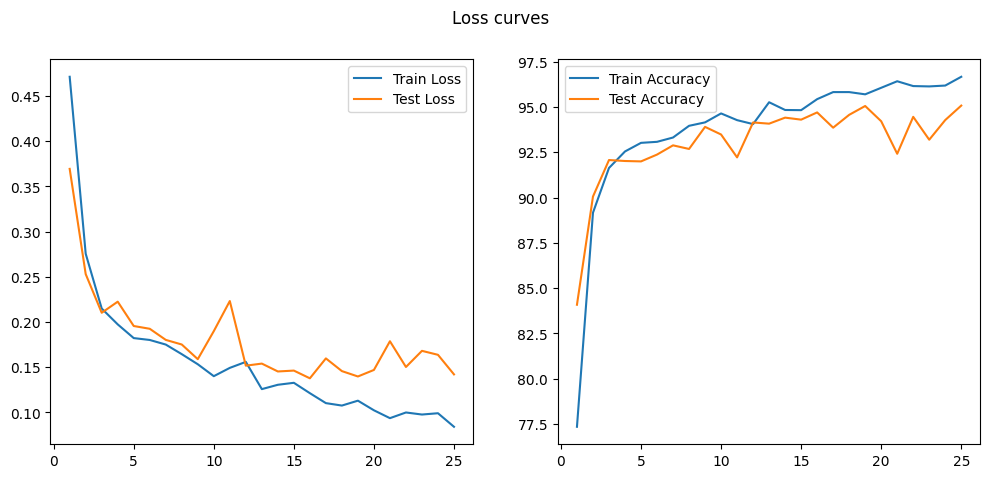

In [15]:
from plot_lib import plot_loss_curves

plot_loss_curves(epochs=results["Epoch"], train_loss=results["Train Loss"], test_loss= results["Test Loss"], train_acc=results["Train Accuracy"], test_acc= results["Test Accuracy"])

## Transfer Learning

### EfficientNetB3

#### With Adam Optimizer

In [16]:
from torchvision.models import efficientnet_b3
from torchvision.models import EfficientNet_B3_Weights

weights = EfficientNet_B3_Weights.DEFAULT
model_4 = efficientnet_b3(weights = weights)

#summary(model_4, input_size = [32,3,224,224], col_names = ("input_size", "output_size", "num_params","trainable"))

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 113MB/s]


  0%|          | 0/10 [00:00<?, ?it/s]

(   Epoch  Train Accuracy  Train Loss  Test Accuracy  Test Loss
 0      1       83.995061    0.374425      90.164007   0.505659
 1      2       88.411854    0.284254      91.396277   0.692802
 2      3       90.330547    0.244555      92.163121   1.174389
 3      4       91.508359    0.220431      92.194149   1.325216
 4      5       91.584347    0.220619      93.293440   0.328736
 5      6       92.743161    0.212095      92.451241   2.144244
 6      7       92.182751    0.209244      93.173759   6.593107
 7      8       93.920973    0.163248      92.907801   0.472865
 8      9       94.376900    0.147096      93.417553  12.236037
 9     10       94.794833    0.152662      92.562057   5.265060,
 None)

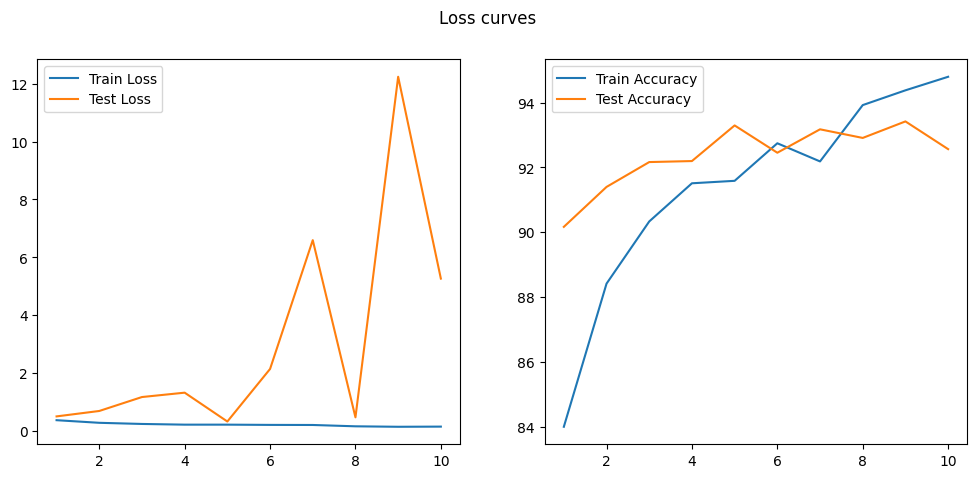

In [17]:
import train_model
train_model.train_efficientnet(model = model_4,
                weights = weights,
                in_features = 1536,
                lr = 0.001,
                optimizer = 'adam',
                train_loader = train_loader,
                test_loader = test_loader,
                classes = classes,
                loss_fn = torch.nn.CrossEntropyLoss(),
                BATCH_SIZE = 32,
                epochs = 10,
                device = device,
                random_state = 42)


#### With SGD Optimizer

  0%|          | 0/10 [00:00<?, ?it/s]

(   Epoch  Train Accuracy  Train Loss  Test Accuracy  Test Loss
 0      1       81.306991    0.440864      87.052305   0.368502
 1      2       87.205547    0.315657      89.822695   0.361857
 2      3       88.991261    0.272567      90.044326   0.432745
 3      4       90.083587    0.249523      83.382092   0.687732
 4      5       90.406535    0.236847      91.032801   0.307450
 5      6       91.194909    0.222221      90.465426   0.437710
 6      7       91.679331    0.208039      91.928191   0.346073
 7      8       92.391717    0.195667      92.282801   0.413136
 8      9       92.192249    0.200078      89.525709   0.369224
 9     10       92.543693    0.182132      91.742021   0.357443,
 None)

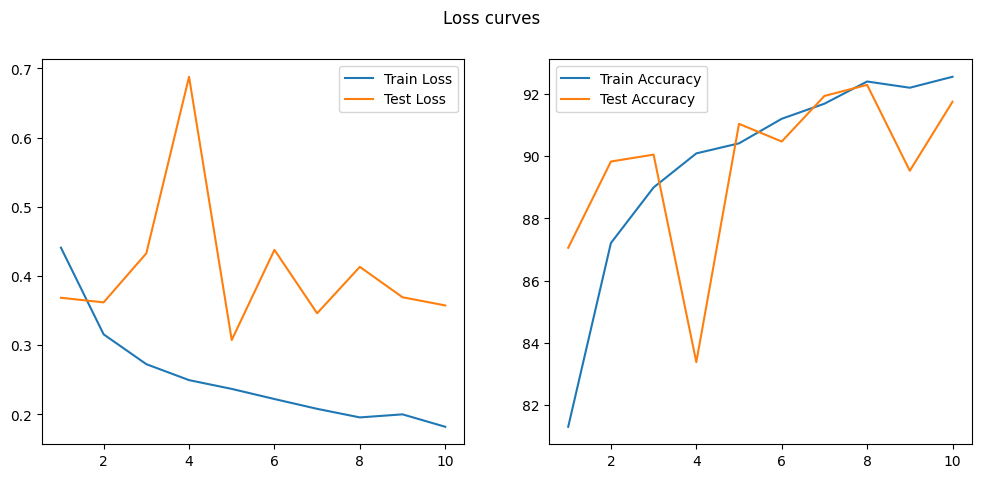

In [18]:
weights = EfficientNet_B3_Weights.DEFAULT
model_4 = efficientnet_b3(weights = weights)

train_model.train_efficientnet(model = model_4,
                weights = weights,
                in_features = 1536,
                lr = 0.1,
                optimizer = 'sgd',
                train_loader = train_loader,
                test_loader = test_loader,
                classes = classes,
                loss_fn = torch.nn.CrossEntropyLoss(),
                BATCH_SIZE = 32,
                epochs = 10,
                device = device,
                random_state = 42)

### ResNet50

#### With Adam Optimizer

In [15]:
from torchvision.models import resnet50
from torchvision.models import ResNet50_Weights
import train_model

weights = ResNet50_Weights.DEFAULT
model_5 = resnet50(weights = weights)
#summary(model_4, input_size = [32,3,224,224], col_names = ("input_size", "output_size", "num_params","trainable"))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 196MB/s]


  0%|          | 0/10 [00:00<?, ?it/s]

(   Epoch  Train Accuracy  Train Loss  Test Accuracy  Test Loss
 0      1       93.189590    0.189579      96.861702   0.124650
 1      2       97.891337    0.068496      96.706560   0.451281
 2      3       98.432751    0.049375      97.393617   0.320190
 3      4       99.069149    0.028172      97.451241   0.616409
 4      5       99.135638    0.031956      97.748227   0.145826
 5      6       99.259119    0.021730      97.992021   0.101232
 6      7       99.563070    0.013650      98.102837   0.124056
 7      8       99.297112    0.021260      97.034574   0.349377
 8      9       99.325608    0.027264      97.903369   1.019456
 9     10       99.439590    0.017650      98.280142   0.240092,
 None)

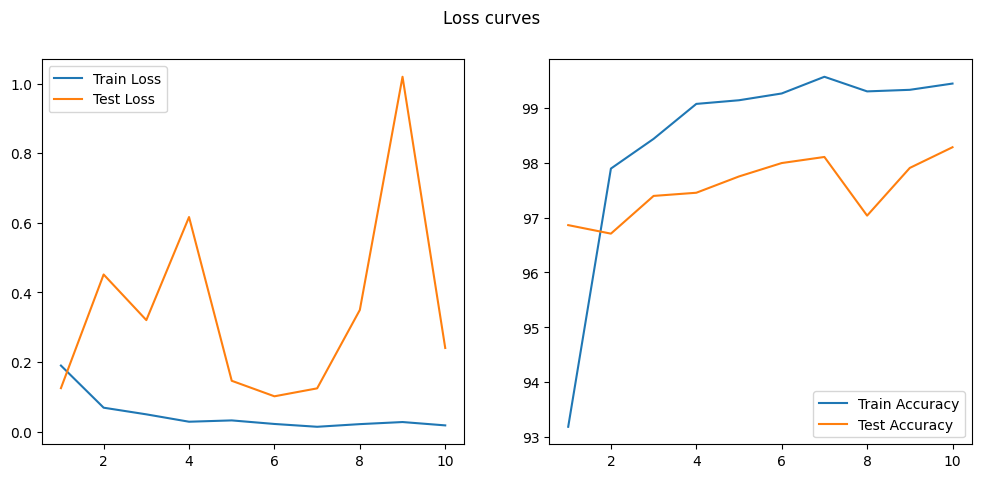

In [16]:
weights = ResNet50_Weights.DEFAULT
model_5 = resnet50(weights = weights)

train_model.train_resnet(model = model_5,
                weights = weights,
                in_features = 2048,
                optimizer = 'adam',
                lr = 0.001,
                train_loader = train_loader,
                test_loader = test_loader,
                classes = classes,
                loss_fn = torch.nn.CrossEntropyLoss(),
                BATCH_SIZE = 32,
                epochs = 10,
                device = device,
                random_state = 42)

  0%|          | 0/7 [00:00<?, ?it/s]

(   Epoch  Train Accuracy  Train Loss  Test Accuracy  Test Loss
 0      1       93.161094    0.185238      95.257092   0.552396
 1      2       97.634878    0.069964      97.451241   0.143968
 2      3       98.480243    0.071143      97.695035   0.319640
 3      4       98.869681    0.032965      97.637411   0.313752
 4      5       99.040653    0.027723      98.067376   0.136283
 5      6       99.135638    0.028800      98.160461   0.093615
 6      7       99.249620    0.022355      98.368794   0.148694,
 None)

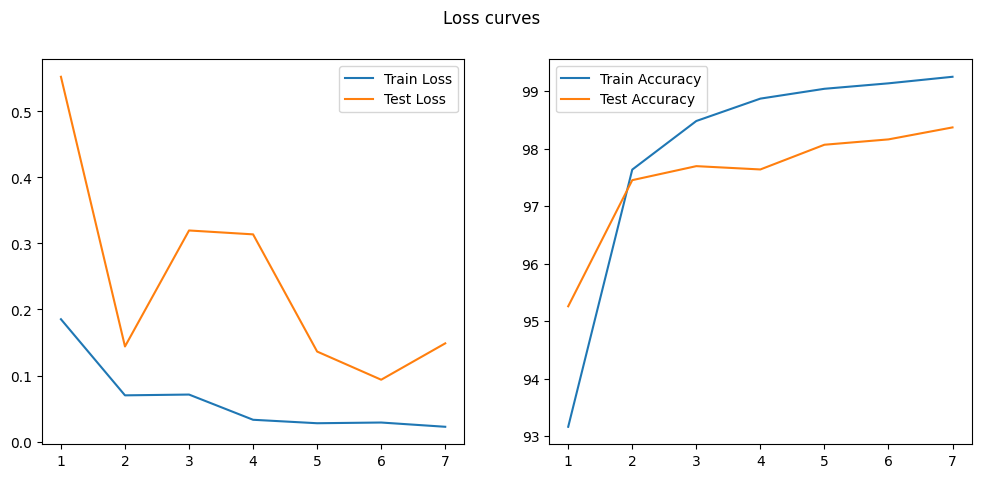

In [17]:
weights = ResNet50_Weights.DEFAULT
model_6 = resnet50(weights = weights)

train_model.train_resnet(model = model_6,
                weights = weights,
                in_features = 2048,
                optimizer = 'adam',
                lr = 0.001,
                train_loader = train_loader,
                test_loader = test_loader,
                classes = classes,
                loss_fn = torch.nn.CrossEntropyLoss(),
                BATCH_SIZE = 32,
                epochs = 7,
                #epochs = 10,
                device = device,
                random_state = 42)

In [48]:
import os
os.makedirs("Model", exist_ok = True)
saved_model_path = "Model/resnet50_7_epochs_adam_lr_0_001.pth"
torch.save(obj = model_6.state_dict(), f = saved_model_path)

#### With SGD optimizer

## Testing Saved Model

Prediction: lung_scc | Actual: lung_n
Probability: 100.0%


(np.float64(-0.5), np.float64(767.5), np.float64(767.5), np.float64(-0.5))

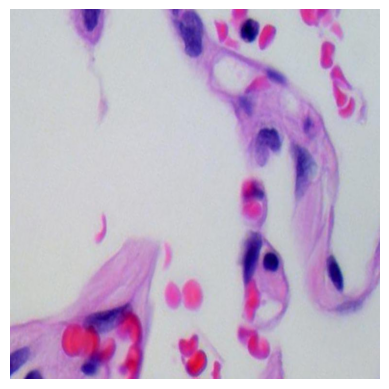

In [18]:
from torchvision.models import resnet50
from torchvision.models import ResNet50_Weights
from predict import predict_single
import random

saved_model_path = "Model/resnet50_7_epochs_adam_lr_0_001.pth"
weights = ResNet50_Weights.DEFAULT
resnet_50 = resnet50(weights = weights)

for param in resnet_50.parameters():
    param.requires_grad = False

resnet_50.fc = nn.Sequential(
        nn.Linear(2048, 512),       # First linear layer to a hidden size of 512
        nn.ReLU(),                         # Non-linear activation function
        nn.Dropout(p=0.2),                 # Dropout for regularization to prevent overfitting
        nn.Linear(512, len(classes))
)

resnet_50.load_state_dict(torch.load(saved_model_path, weights_only=True))

labels = classes
image = random.choice(images_list)
image_label = image.split("/")[-2]

pred, prob = predict_single(model = resnet_50, image = image, device = None, transform = weights.transforms(), labels = labels)

print(f"Prediction: {pred} | Actual: {image_label}\nProbability: {round(prob, 4)*100}%")
plt.imshow(Image.open(image))
plt.axis("off")

## Analysis of Results

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

from predict import batch_predict

weights = ResNet50_Weights.DEFAULT
resnet_50 = resnet50(weights = weights)

ImportError: cannot import name 'batch_predict' from 'predict' (/content/MyDrive/MyDrive/Lung Cancer Detection/predict.py)

## Thank you 🙏